In [107]:
from numpy import cumsum
from datetime import datetime
from typing import List, Tuple

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from Experiments.FundHistorySummary import FundHistorySummary

def show_summary_grid(fund_history_summary: FundHistorySummary) -> None:
    sns.set(rc={'figure.figsize':(26,15)})
    f, axes = plt.subplots(2, 1)

    start_wealth = 500
    bet_limit_fraction = 0.33
    show_fixed_betting_wealth_progression(axes[0], fund_history_summary, start_wealth=start_wealth, betting_limit=100)
    show_dynamic_betting_wealth_progression(axes[1], fund_history_summary, start_wealth=start_wealth, bet_limit_fraction=bet_limit_fraction)

def show_fixed_betting_wealth_progression(axis, fund_history_summary: FundHistorySummary, start_wealth: float, betting_limit: float):
    dates = [snapshot.date.split()[0] for snapshot in fund_history_summary.snapshots]
    absolute_payouts = [snapshot.payout_percentages * betting_limit for snapshot in fund_history_summary.snapshots]
    wealth_progression = [start_wealth + payout_sum for payout_sum in cumsum(absolute_payouts)]

    sns.lineplot(x=dates, y=wealth_progression, ax=axis)

    max_date = datetime.strptime(max(dates), '%Y-%m-%d')
    min_date = datetime.strptime(min(dates), '%Y-%m-%d')
    summary_day_interval = (max_date - min_date).days
    axis.xaxis.set_major_locator(mdates.DayLocator(interval=int(summary_day_interval / 5)))

    axis.set_title(f"Wealth progression over unseen test races. Betting limit is: {betting_limit}")
    axis.set_xlabel(f"Date")
    axis.set_ylabel(f"Current Wealth")

def show_dynamic_betting_wealth_progression(axis, fund_history_summary: FundHistorySummary, start_wealth: float, bet_limit_fraction: float) -> None:
    dates = [snapshot.date.split()[0] for snapshot in fund_history_summary.snapshots]

    current_wealth = start_wealth
    wealth_progression = []
    for i in range(len(fund_history_summary.snapshots)):
        betting_limit = current_wealth * bet_limit_fraction
        current_wealth += fund_history_summary.snapshots[i].payout_percentages * betting_limit
        wealth_progression.append(current_wealth)

    sns.lineplot(x=dates, y=wealth_progression, ax=axis)

    max_date = datetime.strptime(max(dates), '%Y-%m-%d')
    min_date = datetime.strptime(min(dates), '%Y-%m-%d')
    summary_day_interval = (max_date - min_date).days
    axis.xaxis.set_major_locator(mdates.DayLocator(interval=int(summary_day_interval / 5)))

    axis.set_title(f"Wealth progression over unseen test races. Betting limit is current wealth multiplied by {bet_limit_fraction:.2f}")
    axis.set_xlabel(f"Date")
    axis.set_ylabel(f"Current Wealth")

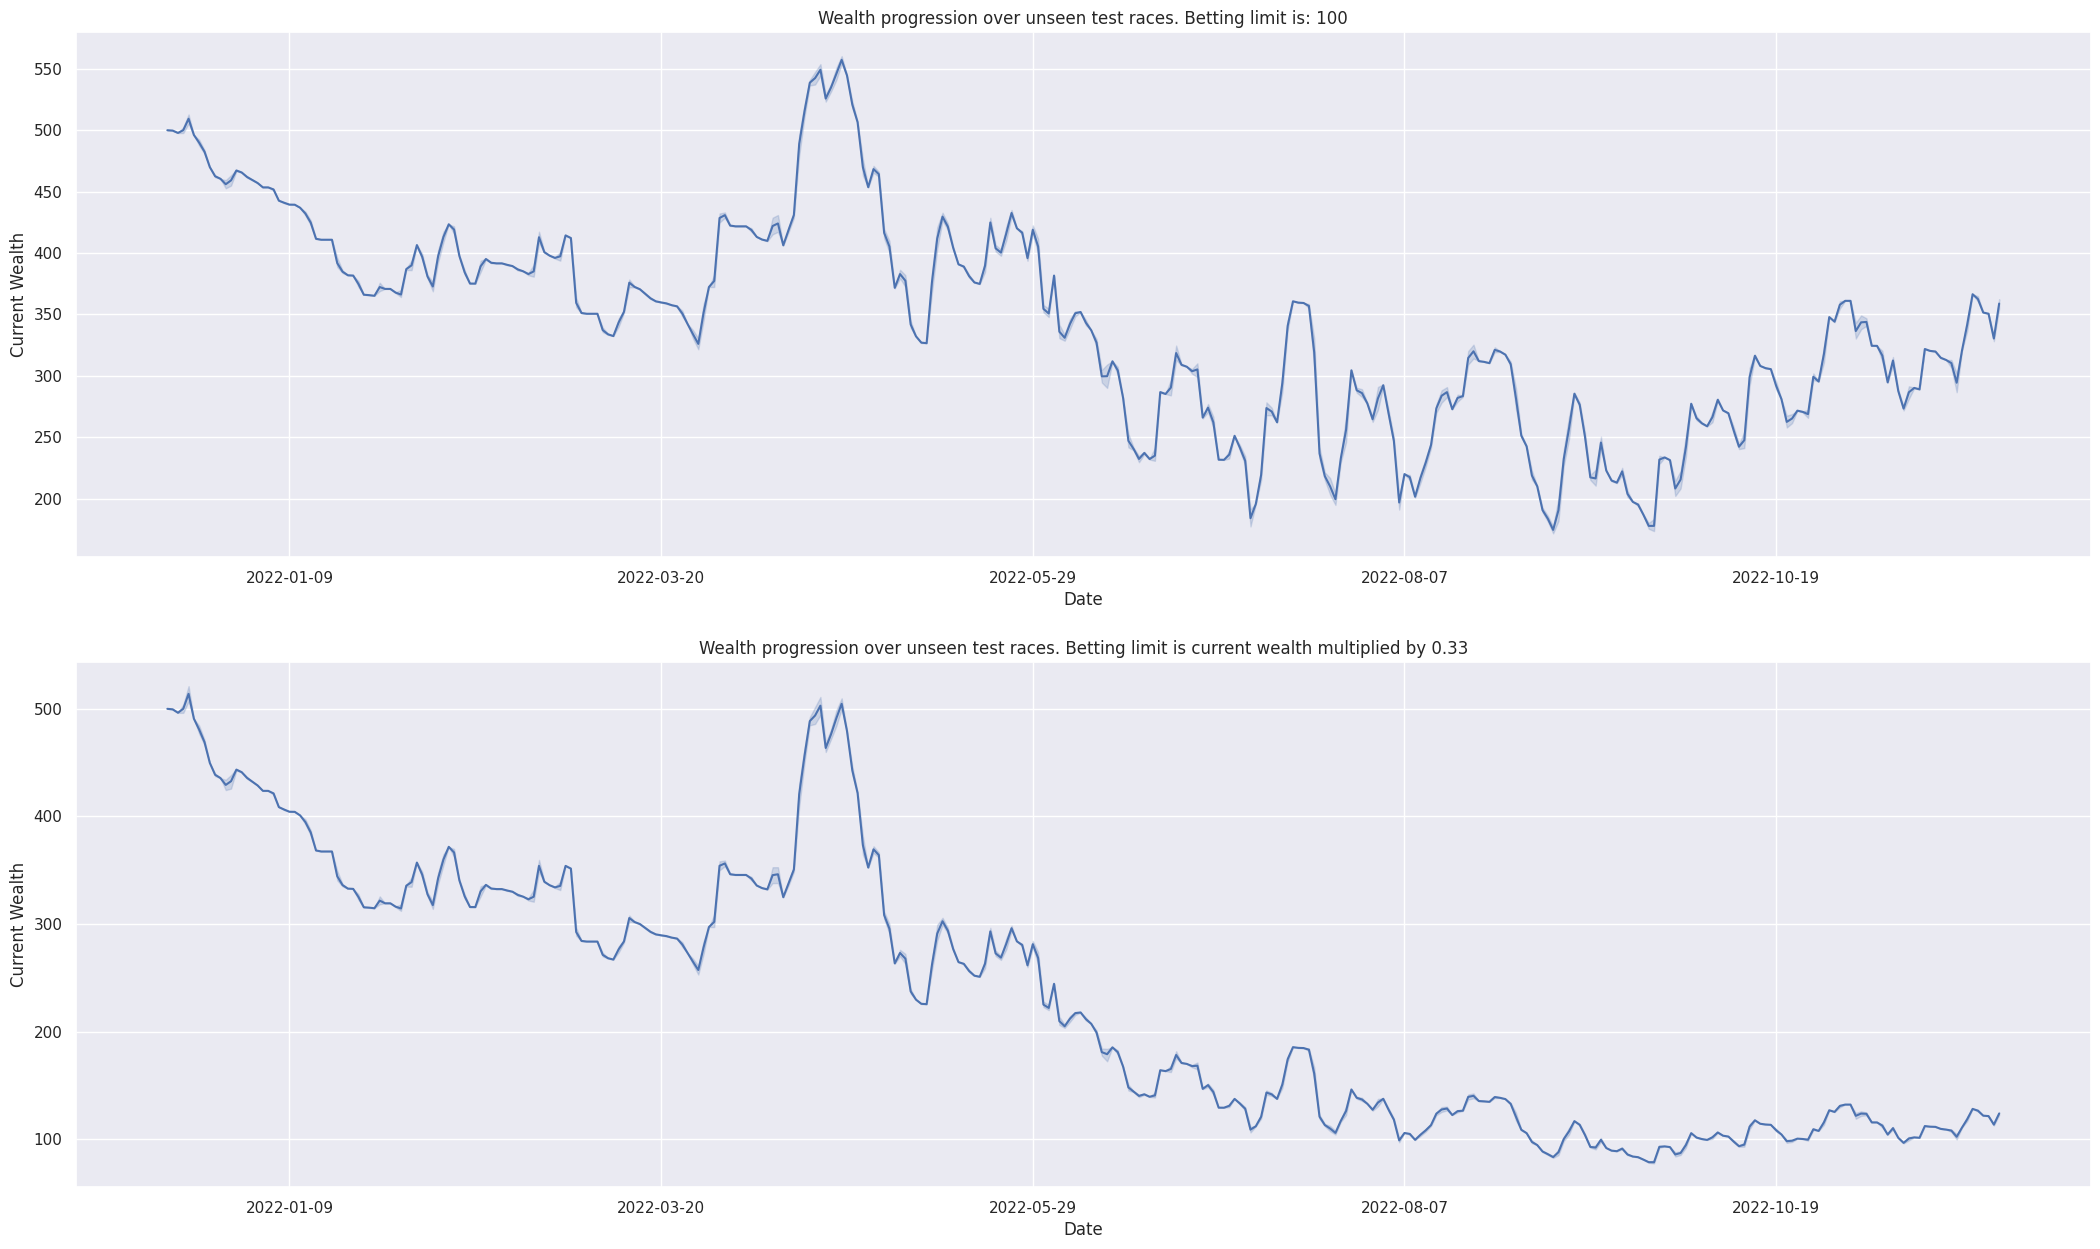

In [108]:
import pickle

FUND_HISTORY_SUMMARIES_PATH = "../data/fund_history_summaries.dat"

with open(FUND_HISTORY_SUMMARIES_PATH, "rb") as f:
    fund_history_summary = pickle.load(f)

show_summary_grid(fund_history_summary)

bet rate: 0.0859
max losses: 0.5839204181794257
min:-0.3714198529389313
max:0.7007045018153111
avg:-0.0001401278958535463


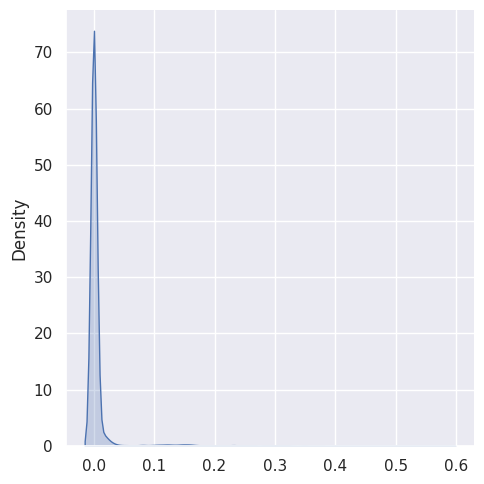

In [109]:
from numpy import average

losses = [betting_slip.loss for betting_slip in fund_history_summary.betting_slips.values()]
payouts = [betting_slip.payout_percentage for betting_slip in fund_history_summary.betting_slips.values()]

print(f"bet rate: {fund_history_summary.bet_rate}")
print(f"max losses: {max(losses)}")
print(f"min:{min(payouts)}")
print(f"max:{max(payouts)}")
print(f"avg:{average(payouts)}")
ax = sns.displot(x=losses, kind="kde", fill=True)

## Real payout plotting

Text(0, 0.5, 'Wealth difference')

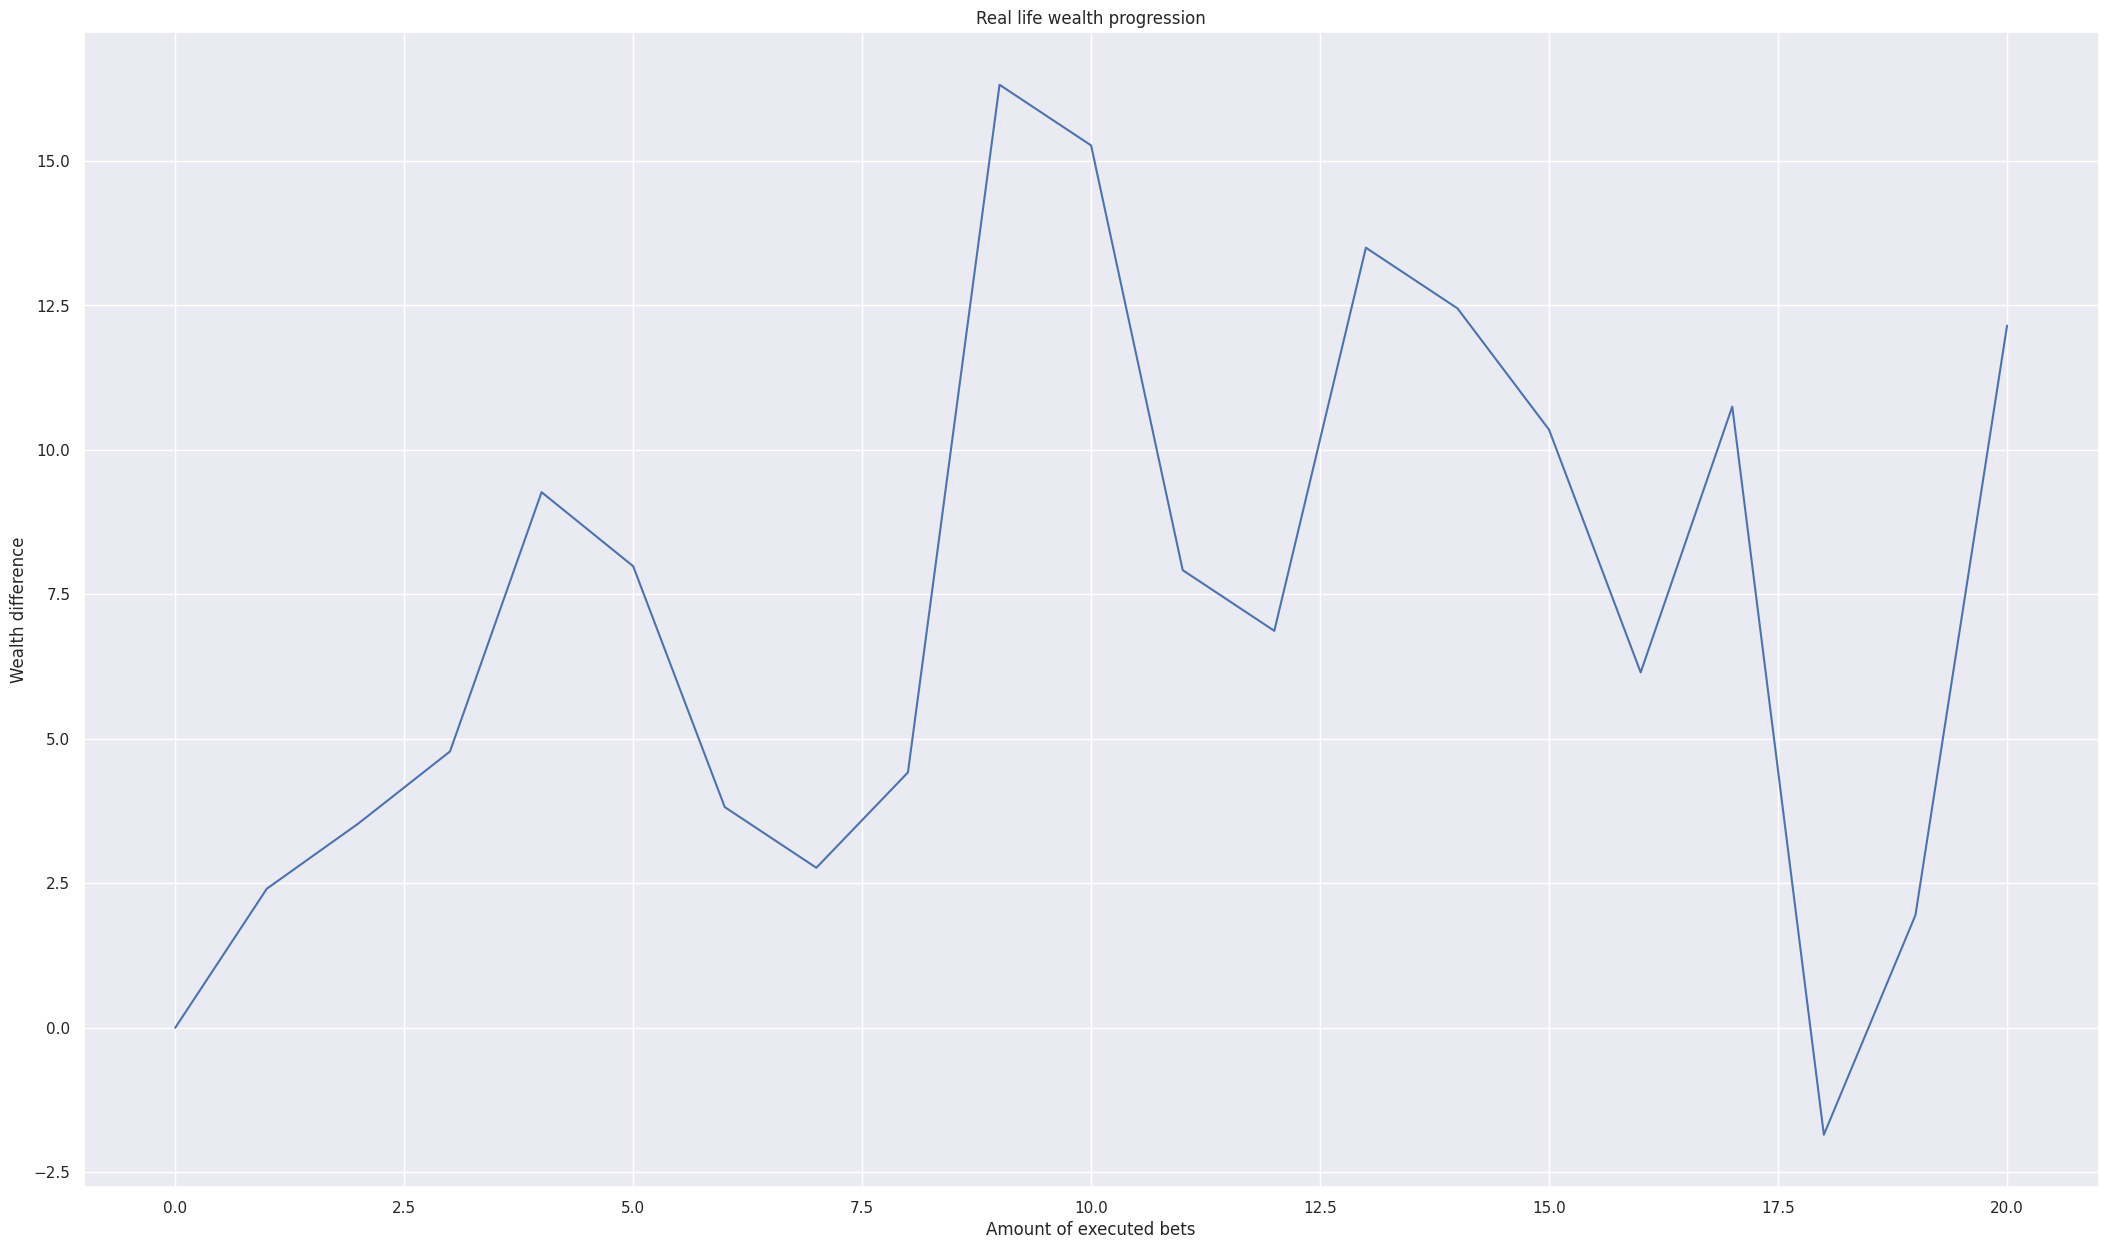

In [32]:
import seaborn as sns
real_payouts = [0,
2.4065,
3.5355,
4.7815,
9.2685,
7.9875,
3.819,
2.769,
4.419,
16.319,
15.269,
7.919,
6.869,
13.499,
12.449,
10.349,
6.149,
10.749,
-1.851,
1.949,
12.149
]

ax = sns.lineplot(real_payouts)
ax.set_title("Real life wealth progression")
ax.set_xlabel("Amount of executed bets")
ax.set_ylabel("Wealth difference")